# Exploratory Data Analysis with SQL

All six queries run directly against the SQLite database built in build_db.ipynb

| Query | What it answers |
|---|---|
| Q1 | How does each issue break down by vote type? |
| Q2 | Which resolutions were most divisive? |
| Q3 | What is each country's voting profile per issue? |
| Q4 | How aligned is every country pair? |
| Q5 | How has US-alignment shifted over time? |
| Q6 | Which sessions were the most active? |

## Setup

In [20]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from pathlib import Path


DB_PATH = Path('/Users/kerematas/Desktop/database/un-votes/un_votes.db')
conn    = sqlite3.connect(DB_PATH)

print('Connected to', DB_PATH.name)
print('Tables:', [r[0] for r in conn.execute("SELECT name FROM sqlite_master WHERE type='table'").fetchall()])

Connected to un_votes.db
Tables: ['countries', 'resolutions', 'issues', 'res_issues', 'votes']


---
## Q1. Vote Distribution per Issue

**Question:** For each of the 6 issue categories, how do votes break down across YES / NO / ABSTAIN / ABSENT?

In [21]:
q1 = pd.read_sql("""
    SELECT
        i.issue_name,
        i.issue_id,
        v.votecast,
        COUNT(*)                                                   AS vote_count,
        ROUND(
            100.0 * COUNT(*)
            / SUM(COUNT(*)) OVER (PARTITION BY i.issue_id)
        , 1)                                                       AS pct
    FROM votes v
    JOIN res_issues ri USING (res_id)
    JOIN issues     i  USING (issue_id)
    GROUP BY i.issue_id, i.issue_name, v.votecast
    ORDER BY i.issue_name, vote_count DESC
""", conn)

q1

,issue_name,issue_id,votecast,vote_count,pct
0,Arms Control & Disarmament,DI,YES,133226,76.6
1,Arms Control & Disarmament,DI,ABSTAIN,18278,10.5
2,Arms Control & Disarmament,DI,ABSENT,13349,7.7
3,Arms Control & Disarmament,DI,NO,9136,5.3
4,Colonialism,CO,YES,104079,75.8
5,Colonialism,CO,ABSTAIN,14919,10.9
6,Colonialism,CO,ABSENT,11747,8.6
7,Colonialism,CO,NO,6487,4.7
8,Economic Development,EC,YES,88256,77.0
9,Economic Development,EC,ABSTAIN,11154,9.7


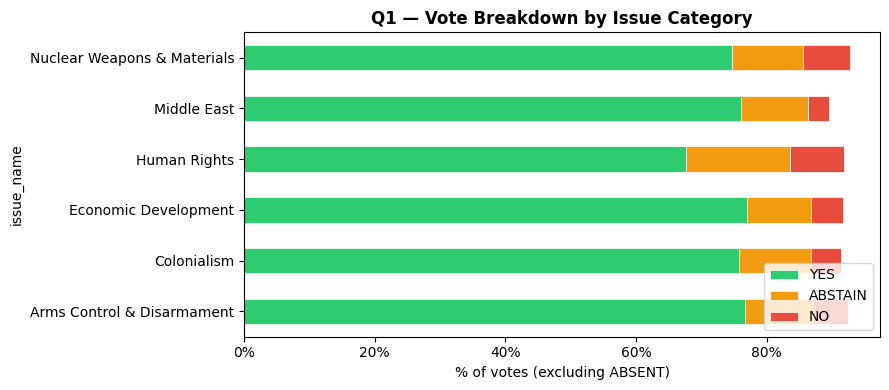

In [22]:
# Visualise
pivot = (
    q1[q1['votecast'].isin(['YES','NO','ABSTAIN'])]
    .pivot(index='issue_name', columns='votecast', values='pct')
    .fillna(0)[['YES','ABSTAIN','NO']]
)

fig, ax = plt.subplots(figsize=(9, 4))
pivot.plot(kind='barh', stacked=True, ax=ax,
           color=['#2ecc71','#f39c12','#e74c3c'],
           edgecolor='white', linewidth=0.5)
ax.set_xlabel('% of votes (excluding ABSENT)')
ax.set_title('Q1 — Vote Breakdown by Issue Category', fontweight='bold')
ax.legend(loc='lower right')
ax.xaxis.set_major_formatter(mticker.PercentFormatter())
plt.tight_layout()
plt.show()

---
## Q2. Most Divisive Resolutions

**Question:** Which resolutions attracted the highest share of NO votes? These are the sharpest fault lines in global politics.

In [23]:
q2 = pd.read_sql("""
    WITH vote_counts AS (
        SELECT
            res_id,
            COUNT(*)                                                    AS total_votes,
            SUM(CASE WHEN votecast = 'YES'     THEN 1 ELSE 0 END)      AS yes_votes,
            SUM(CASE WHEN votecast = 'NO'      THEN 1 ELSE 0 END)      AS no_votes,
            SUM(CASE WHEN votecast = 'ABSTAIN' THEN 1 ELSE 0 END)      AS abstain_votes
        FROM votes
        GROUP BY res_id
    ),
    ranked AS (
        SELECT
            vc.*,
            r.year,
            r.description,
            ROUND(100.0 * vc.no_votes  / vc.total_votes, 1)            AS no_pct,
            ROUND(100.0 * vc.yes_votes / vc.total_votes, 1)            AS yes_pct,
            RANK() OVER (ORDER BY 1.0 * vc.no_votes / vc.total_votes DESC) AS divisiveness_rank
        FROM vote_counts vc
        JOIN resolutions r USING (res_id)
        WHERE vc.total_votes >= 50
    )
    SELECT
        divisiveness_rank AS rank,
        res_id,
        year,
        yes_votes,
        no_votes,
        abstain_votes,
        no_pct,
        yes_pct,
        description
    FROM ranked
    WHERE divisiveness_rank <= 20
    ORDER BY divisiveness_rank
""", conn)

q2[['rank','res_id','year','yes_votes','no_votes','abstain_votes','no_pct','description']]

,rank,res_id,year,yes_votes,no_votes,abstain_votes,no_pct,description
0,1,R/5/235D,1950,5,55,0,91.7,TO ADOPT USSR DRAFT RESOL. (A/1428) CALLING FO...
1,2,R/5/235C,1950,5,52,3,86.7,TO ADOPT USSR DRAFT RESOLUTION (A/1427) CALLIN...
2,3,R/15/1386,1960,1,82,9,82.0,TO ADOPT S. AFRICA PROPOSAL ADJOURNING DEBATE ...
3,4,R/7/132A,1952,5,46,7,76.7,TO ADOPT USSR ORAL PROPOSAL INVITING REPRESENT...
4,5,R/7/530,1952,5,45,10,75.0,TO ADOPT USSR DRAFT RESOL. (A/2335) CONDEMNING...
5,6,R/3/611,1949,2,43,10,72.9,TO ADOPT PRESIDENT'S PROCEDURAL RULING AGAINST...
6,7,R/2/465,1947,6,41,10,71.9,TO ADOPT USSR DRAFT RESOL. (A/C91/199) CALLING...
7,8,R/7/332,1952,6,43,9,71.7,TO ADOPT UNION OF S. AFRICA RESOLUTION (A/L.12...
8,9,R/6/313,1952,5,42,11,70.0,TO ADOPT USSR DRAFT RESOL. (A/2031) CONDEMNING...
9,9,R/8/436,1953,8,42,10,70.0,TO ADOPT S. AFRICA DRAFT RESOLUTION (A/L.172) ...


---
## Q3. Country Voting Profile per Issue

**Question:** For each country × issue combination, what percentage of votes were YES / NO / ABSTAIN?

In [24]:
q3 = pd.read_sql("""
    WITH issue_votes AS (
        SELECT
            v.country_id,
            ri.issue_id,
            COUNT(*)                                                    AS total,
            SUM(CASE WHEN v.votecast = 'YES'     THEN 1 ELSE 0 END)    AS yes_n,
            SUM(CASE WHEN v.votecast = 'NO'      THEN 1 ELSE 0 END)    AS no_n,
            SUM(CASE WHEN v.votecast = 'ABSTAIN' THEN 1 ELSE 0 END)    AS abstain_n
        FROM votes v
        JOIN res_issues ri USING (res_id)
        GROUP BY v.country_id, ri.issue_id
    )
    SELECT
        c.country_name,
        iv.country_id,
        iv.issue_id,
        iv.total                                                        AS votes_cast,
        ROUND(100.0 * iv.yes_n     / iv.total, 1)                      AS yes_pct,
        ROUND(100.0 * iv.no_n      / iv.total, 1)                      AS no_pct,
        ROUND(100.0 * iv.abstain_n / iv.total, 1)                      AS abstain_pct
    FROM issue_votes iv
    JOIN countries c USING (country_id)
    ORDER BY iv.country_id, iv.issue_id
""", conn)

print(f'Shape: {q3.shape}  ({q3["country_id"].nunique()} countries × {q3["issue_id"].nunique()} issues)')
q3.head(12)

Shape: (1183, 7)  (198 countries × 6 issues)


,country_name,country_id,issue_id,votes_cast,yes_pct,no_pct,abstain_pct
0,Afghanistan,AFG,CO,842,86.5,1.4,2.1
1,Afghanistan,AFG,DI,994,87.3,1.6,5.2
2,Afghanistan,AFG,EC,690,84.3,2.9,5.9
3,Afghanistan,AFG,HR,944,79.2,6.6,4.4
4,Afghanistan,AFG,ME,1009,87.5,1.5,0.3
5,Afghanistan,AFG,NU,748,88.9,0.1,5.7
6,Angola,AGO,CO,635,85.4,0.6,1.7
7,Angola,AGO,DI,919,78.0,0.3,5.8
8,Angola,AGO,EC,565,81.4,0.7,3.2
9,Angola,AGO,HR,829,75.6,2.5,13.3


In [25]:
feature_matrix = (
    q3.pivot(index='country_id', columns='issue_id', values='yes_pct')
    .dropna()   # drop countries missing any issue (too few votes)
)
feature_matrix.columns = [f'yes_pct_{c}' for c in feature_matrix.columns]
feature_matrix = feature_matrix.reset_index()

print(f'Feature matrix shape: {feature_matrix.shape}  (countries × issue-yes-rates)')
feature_matrix.head(8)

Feature matrix shape: (197, 7)  (countries × issue-yes-rates)


,country_id,yes_pct_CO,yes_pct_DI,yes_pct_EC,yes_pct_HR,yes_pct_ME,yes_pct_NU
0,AFG,86.5,87.3,84.3,79.2,87.5,88.9
1,AGO,85.4,78.0,81.4,75.6,79.4,80.2
2,ALB,69.1,41.0,46.0,51.0,71.0,38.0
3,AND,68.8,59.7,69.8,48.6,72.5,49.3
4,ARE,95.5,92.4,92.5,85.3,99.1,97.5
5,ARG,81.7,77.8,90.0,79.6,84.9,71.3
6,ARM,76.9,60.7,74.9,63.6,83.1,50.1
7,ATG,81.3,86.2,79.3,75.5,69.1,85.7


---
## Q4. Pairwise Country Agreement Rate

**Question:** For every pair of countries, what fraction of shared resolutions did they vote identically (both YES, both NO, or both ABSTAIN)?

In [26]:
q4 = pd.read_sql("""
    WITH active AS (
        -- Exclude ABSENT votes: absence isn't a policy position,
        -- so we only measure alignment on resolutions both countries actively voted on.
        SELECT country_id, res_id, votecast
        FROM   votes
        WHERE  votecast != 'ABSENT'
    )
    SELECT
        a.country_id                                                    AS country_a,
        b.country_id                                                    AS country_b,
        COUNT(*)                                                        AS shared_votes,
        SUM(CASE WHEN a.votecast = b.votecast THEN 1 ELSE 0 END)       AS agreed,
        ROUND(
            100.0 * SUM(CASE WHEN a.votecast = b.votecast THEN 1 ELSE 0 END)
            / COUNT(*)
        , 2)                                                            AS agreement_pct
    FROM   active a
    JOIN   active b
           ON  a.res_id      = b.res_id
           AND a.country_id  < b.country_id   -- canonical ordering avoids duplicate pairs
    GROUP  BY a.country_id, b.country_id
    HAVING shared_votes >= 100
    ORDER  BY agreement_pct DESC
""", conn)

print(f'Country pairs computed: {len(q4):,}')
q4.head(10)

Country pairs computed: 19,121


,country_a,country_b,shared_votes,agreed,agreement_pct
0,BLR,DDR,1957,1937,98.98
1,DDR,UKR,1958,1937,98.93
2,BGR,CSK,2679,2647,98.81
3,DDR,MNG,1930,1906,98.76
4,CSK,DDR,1960,1935,98.72
5,DDR,RUS,1959,1934,98.72
6,CSK,HUN,2651,2615,98.64
7,BGR,DDR,1961,1934,98.62
8,SYC,TLS,562,552,98.22
9,DDR,HUN,1952,1917,98.21


In [27]:
print('Most ALIGNED pairs:')
print(q4.head(8).to_string(index=False))
print()
print('Most OPPOSED pairs:')
print(q4.tail(8).to_string(index=False))

Most ALIGNED pairs:
country_a country_b  shared_votes  agreed  agreement_pct
      BLR       DDR          1957    1937          98.98
      DDR       UKR          1958    1937          98.93
      BGR       CSK          2679    2647          98.81
      DDR       MNG          1930    1906          98.76
      CSK       DDR          1960    1935          98.72
      DDR       RUS          1959    1934          98.72
      CSK       HUN          2651    2615          98.64
      BGR       DDR          1961    1934          98.62

Most OPPOSED pairs:
country_a country_b  shared_votes  agreed  agreement_pct
      TKM       USA          1365     191          13.99
      MOZ       USA          3876     541          13.96
      STP       USA          2523     351          13.91
      AGO       USA          3499     442          12.63
      USA       ZWE          3303     416          12.59
      USA       VNM          3802     426          11.20
      ISR       PRK          1986     201      

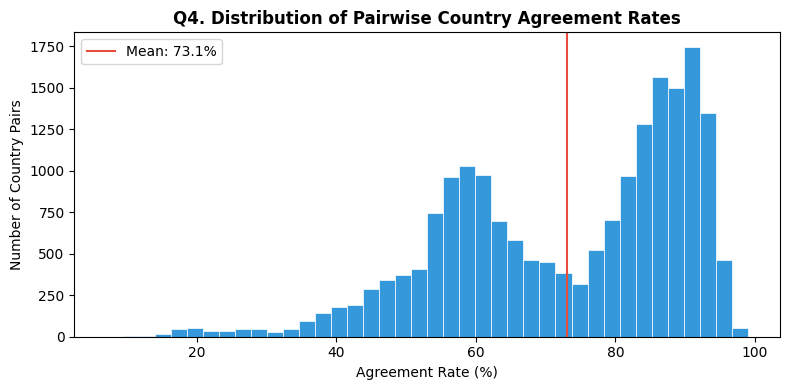

In [28]:
# Distribution of agreement rates across all pairs
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(q4['agreement_pct'], bins=40, color='#3498db', edgecolor='white', linewidth=0.5)
ax.axvline(q4['agreement_pct'].mean(), color='#e74c3c', linewidth=1.5,
           label=f'Mean: {q4["agreement_pct"].mean():.1f}%')
ax.set_xlabel('Agreement Rate (%)')
ax.set_ylabel('Number of Country Pairs')
ax.set_title('Q4. Distribution of Pairwise Country Agreement Rates', fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

---
## Q5. US Alignment Over Time

**Question:** For a set of key countries, how has their voting agreement with the United States changed decade by decade?

Do Cold War allegiances predict modern voting blocs?


In [29]:
q5 = pd.read_sql("""
    WITH us_votes AS (
        SELECT res_id, votecast AS us_vote
        FROM   votes
        WHERE  country_id = 'USA'
          AND  votecast  != 'ABSENT'
    ),
    decade_agreement AS (
        SELECT
            v.country_id,
            (v.year / 10) * 10                                          AS decade,
            COUNT(*)                                                     AS shared_votes,
            SUM(CASE WHEN v.votecast = uv.us_vote THEN 1 ELSE 0 END)    AS agreed,
            ROUND(
                100.0 * SUM(CASE WHEN v.votecast = uv.us_vote THEN 1 ELSE 0 END)
                / COUNT(*)
            , 1)                                                         AS us_agreement_pct
        FROM   votes v
        JOIN   us_votes uv USING (res_id)
        WHERE  v.country_id != 'USA'
          AND  v.votecast   != 'ABSENT'
        GROUP  BY v.country_id, decade
        HAVING shared_votes >= 20
    )
    SELECT
        c.country_name,
        da.country_id,
        da.decade,
        da.shared_votes,
        da.us_agreement_pct
    FROM   decade_agreement da
    JOIN   countries c USING (country_id)
    ORDER  BY da.country_id, da.decade
""", conn)

print(f'Shape: {q5.shape}')
q5.head(10)

Shape: (1328, 5)


,country_name,country_id,decade,shared_votes,us_agreement_pct
0,Afghanistan,AFG,1940,73,39.7
1,Afghanistan,AFG,1950,227,40.5
2,Afghanistan,AFG,1960,203,25.1
3,Afghanistan,AFG,1970,765,28.9
4,Afghanistan,AFG,1980,1307,7.6
5,Afghanistan,AFG,1990,585,18.8
6,Afghanistan,AFG,2000,578,11.9
7,Afghanistan,AFG,2010,640,17.2
8,Afghanistan,AFG,2020,217,19.4
9,Angola,AGO,1970,250,21.2


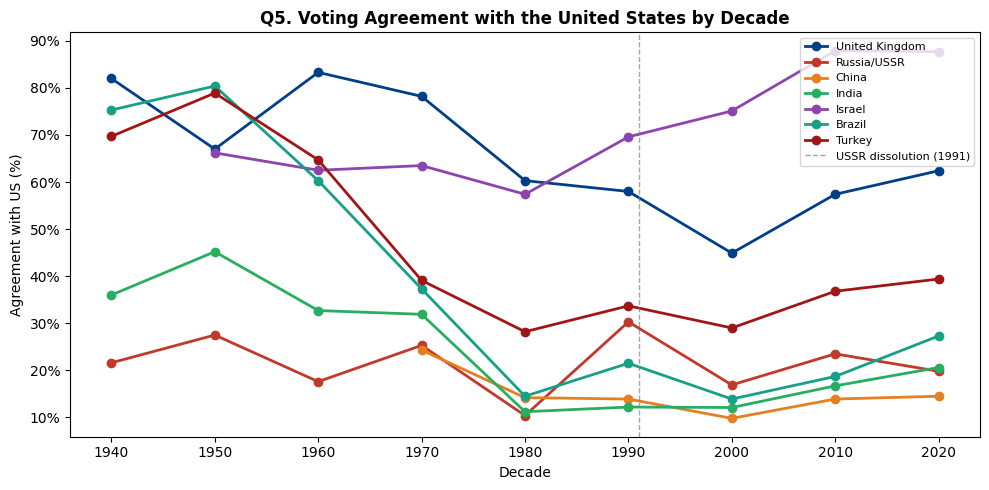

In [30]:
# Visualise a few telling countries across decades
HIGHLIGHT = {
    'GBR': ('United Kingdom', '#003f88'),
    'RUS': ('Russia/USSR',    '#c0392b'),
    'CHN': ('China',          '#e67e22'),
    'IND': ('India',          '#27ae60'),
    'ISR': ('Israel',         '#8e44ad'),
    'BRA': ('Brazil',         '#16a085'),
    'TUR': ('Turkey',         "#a01616"),
    
}

fig, ax = plt.subplots(figsize=(10, 5))

for cid, (label, color) in HIGHLIGHT.items():
    subset = q5[q5['country_id'] == cid].sort_values('decade')
    if not subset.empty:
        ax.plot(subset['decade'], subset['us_agreement_pct'],
                marker='o', label=label, color=color, linewidth=2)

ax.axvline(1991, color='grey', linestyle='--', linewidth=1, alpha=0.7, label='USSR dissolution (1991)')
ax.set_xlabel('Decade')
ax.set_ylabel('Agreement with US (%)')
ax.set_title('Q5. Voting Agreement with the United States by Decade', fontweight='bold')
ax.legend(loc='upper right', fontsize=8)
ax.yaxis.set_major_formatter(mticker.PercentFormatter())
plt.tight_layout()
plt.show()

---
## Q6. Most Active Sessions

**Question:** Which UNGA sessions produced the most resolutions, and how does activity break down by issue?

In [31]:
q6 = pd.read_sql("""
    WITH session_stats AS (
        SELECT
            r.session,
            MIN(r.year)                                                  AS year,
            COUNT(DISTINCT r.res_id)                                     AS total_resolutions,
            COUNT(DISTINCT ri.res_id)                                    AS tagged_resolutions,
            COUNT(DISTINCT ri.issue_id)                                  AS issues_covered,
            SUM(r.total_yes + r.total_no + r.total_abstain)             AS total_votes_cast,
            ROW_NUMBER() OVER (
                ORDER BY COUNT(DISTINCT r.res_id) DESC
            )                                                            AS rank_by_volume
        FROM       resolutions r
        LEFT JOIN  res_issues  ri USING (res_id)
        GROUP BY   r.session
    )
    SELECT *
    FROM   session_stats
    ORDER  BY rank_by_volume
    LIMIT  15
""", conn)

q6

,session,year,total_resolutions,tagged_resolutions,issues_covered,total_votes_cast,rank_by_volume
0,41,1986,155,105,6,29877,1
1,40,1985,155,107,6,29287,2
2,39,1984,150,106,6,28230,3
3,42,1987,146,95,6,27279,4
4,38,1983,145,107,6,28828,5
5,37,1982,144,105,6,27155,6
6,43,1988,136,93,6,26226,7
7,36,1981,131,92,6,24310,8
8,33,1978,130,83,6,21526,9
9,34,1979,117,73,6,20504,10


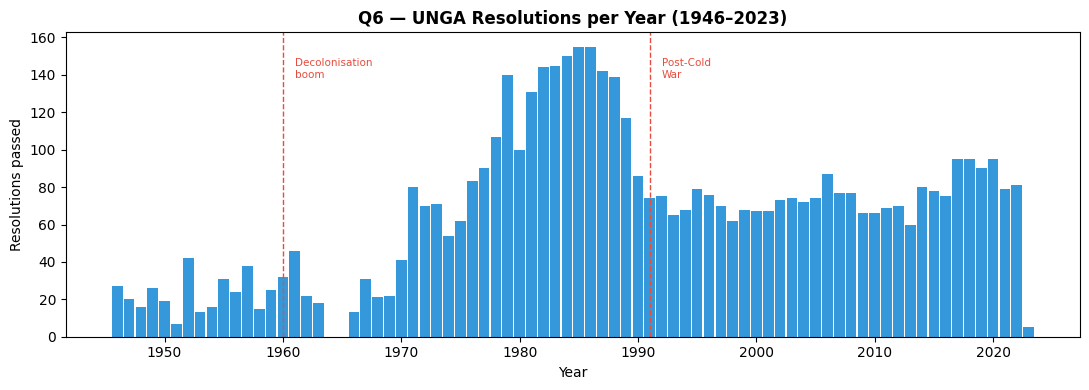

In [32]:
# Resolutions per year
res_per_year = pd.read_sql("""
    SELECT year, COUNT(*) AS resolutions
    FROM   resolutions
    GROUP  BY year
    ORDER  BY year
""", conn)

fig, ax = plt.subplots(figsize=(11, 4))
ax.bar(res_per_year['year'], res_per_year['resolutions'],
       color='#3498db', edgecolor='none', width=0.9)
ax.set_xlabel('Year')
ax.set_ylabel('Resolutions passed')
ax.set_title('Q6 — UNGA Resolutions per Year (1946–2023)', fontweight='bold')
# Annotate a few historical moments
for yr, label in [(1960,'Decolonisation\nboom'), (1991,'Post-Cold\nWar')]:
    ax.axvline(yr, color='#e74c3c', linestyle='--', linewidth=1)
    ax.text(yr+1, ax.get_ylim()[1]*0.85, label, fontsize=7.5, color='#e74c3c')
plt.tight_layout()
plt.show()

---
## Save Intermediate Results

In [33]:
import pickle
from pathlib import Path

OUT = Path('/Users/kerematas/Desktop/database/un-votes/pipeline')

artifacts = {
    'q1_issue_vote_dist':  q1,
    'q2_divisive':         q2,
    'q3_country_profiles': q3,
    'q3_feature_matrix':   feature_matrix,
    'q4_agreement_pairs':  q4,
    'q5_us_alignment':     q5,
    'q6_sessions':         q6,
}

with open(OUT / 'sql_results.pkl', 'wb') as f:
    pickle.dump(artifacts, f)

print('Saved sql_results.pkl')
for name, df in artifacts.items():
    print(f'  {name}: {df.shape}')

conn.close()

Saved sql_results.pkl
  q1_issue_vote_dist: (24, 5)
  q2_divisive: (21, 9)
  q3_country_profiles: (1183, 7)
  q3_feature_matrix: (197, 7)
  q4_agreement_pairs: (19121, 5)
  q5_us_alignment: (1328, 5)
  q6_sessions: (15, 7)
